In [1]:
import nltk
import re
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer # or LancasterStemmer, RegexpStemmer, SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [2]:
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english') # or any other list of your chose

In [3]:
def clean_text(text, ):
    
    latin_replacement = {'Ã\x83Â¡':'a',
                        'Ã\x83Â©':'e',
                        'Ã\x83Â\xad':'i',
                        'Ã\x83Â³':'o',    
                        'Ã\x83Âº':'u'}
    
    def tokenize_text(text):
        return [w for s in sent_tokenize(text) for w in word_tokenize(s)]

    def remove_special_characters(text, characters=string.punctuation.replace('-', '')):
        tokens = tokenize_text(text)
        pattern = re.compile('[{}]'.format(re.escape(characters)))
        return ' '.join(filter(None, [pattern.sub('', t) for t in tokens if t.isalpha()]))

    def stem_text(text, stemmer=default_stemmer):
        tokens = tokenize_text(text)
        return ' '.join([stemmer.stem(t) for t in tokens])
   
    def convert_latin(text):
        pattern = re.compile('|'.join(latin_replacement.keys()))
        result = pattern.sub(lambda x: latin_replacement[x.group()], text)
        return result
    
    def remove_text_in_bracket(text):
        return re.sub("[\[].*?[\]]", "", text)

    def remove_stopwords(text, stop_words=default_stopwords):
        tokens = [w for w in tokenize_text(text) if w not in stop_words]
        return ' '.join(tokens)

    text = text.strip(' ') #strip whitespace
    text = text.lower() #lowercase
    text = remove_special_characters(text) #remove punctuation and symbols
    text = stem_text(text) #stemming
    text = remove_text_in_bracket(text) #remove text within brackets
    text = remove_stopwords(text) #remove stopwords

    return text

In [4]:
# Import lyrics csv
df = pd.read_csv('lyrics.csv', engine='python', index_col=['index'])

In [5]:
# Drop rows containing NAs, and reset index
df.dropna(inplace=True)
df.reset_index(inplace = True, drop= True)

In [6]:
# Get only top 10000 rows and clean them
clean_lyrics = df.loc[:10000,'lyrics'].map(clean_text)

In [ ]:
clean_lyrics.to_csv('clean_lyrics.csv', index = False)

1. Countvectorizer
2. sort by frequency high->low
3. plot log rank vs log freq
4. get head words and tail words
5. re-run data cleaning process - remove head and tail
6. Feature selection - entropy, 

In [7]:
# Count vectorizer to get word counts for all words in vocabulary
cv = CountVectorizer()
cv_fit=cv.fit_transform(clean_lyrics)

In [8]:
# Get Vocabulary
tf_matrix_word = cv.get_feature_names()

# Get word frequency for each word in vocabulary
tf_matrix = cv_fit.toarray()
tf_matrix_freq = tf_matrix.sum(axis = 0)

In [9]:
# Create term frequency dataframe which contains list of words and their frequency in the document
tf_df = pd.DataFrame({'word':tf_matrix_word, 'freq':tf_matrix_freq})

In [10]:
# Sort the words in tf_df by word frequency in descending order
tf_df.sort_values(by='freq',ascending=False, inplace=True)

# The index column will be used will be used to remove head and tail words
tf_df.reset_index(inplace=True)

# The level_0 column will be used to assign rank to the word frequency, words with highest frequency
# get top rank
tf_df.reset_index(inplace=True)
tf_df.rename(columns={'level_0':'rank'}, inplace = True)

In [11]:
tf_df['log_rank'] = np.log(tf_df['rank']+1)
tf_df['log_freq'] = np.log(tf_df['freq']+1)

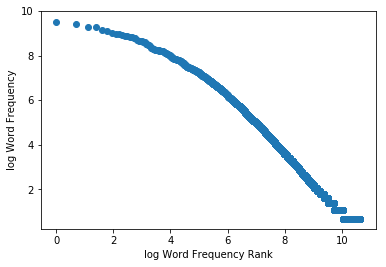

In [13]:
# Plot log rank vs log word frequency
plt.scatter(x = tf_df['log_rank'], y = tf_df['log_freq'])
plt.xlabel('log Word Frequency Rank')
plt.ylabel('log Word Frequency')
plt.show()

In [23]:
# Get head words
# Remove 20 words with highest frequency as head words
head_word_count = 20
head_words = list(tf_df['index'].head(head_word_count))

# Get tail words
# Remove 20 words with frequency less than 5 as tail words
tail_word_freq = 5
tail_words = list(tf_df.loc[tf_df['freq']<tail_word_freq,'index'])

# Combine head and tail words
head_words.extend(tail_words)

In [24]:
# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(clean_lyrics)

c:\users\rohan bapat\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [28]:
# Convert tfidf to numpy array
tfidf = tfidf.toarray()

# Remove head and tail words
X = np.delete(tfidf, head_words, axis  = 1)

In [37]:
y = df.loc[:10000,'genre']

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score

c:\users\rohan bapat\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [34]:
k_fold = KFold(len(y), n_folds=10, shuffle=True, random_state=0)
clf = MultinomialNB()

In [38]:
print(cross_val_score(clf, X, y, cv=k_fold, n_jobs=1))

[0.483 0.496 0.468 0.482 0.469 0.487 0.489 0.472 0.482 0.483]


In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = MultinomialNB()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
accuracy = sum(np.equal(preds,np.array(y_test)))/len(preds)
print(accuracy)

0.47743108149045743


Use nltk naive bayes classifier

In [ ]:
nltk_clf = nltk.NaiveBayesClassifier.train(X_train)

In [ ]:
nltk_clf.show_most_informative_features(15)

In [ ]:
print(nltk_clf.classify(features_all('great')))
print(nltk_clf.classify(features_all('bad')))
print('Accuracy for Naive Bayes: ',nltk.classify.accuracy(nltk_clf, X_test))

Feature selection using chi squared test

In [ ]:
from sklearn.feature_selection import chi2

In [ ]:
chi2(X, y)